In [1]:
import numpy as np
np.set_printoptions(precision=2)

In [2]:
import argparse
from natsort import natsorted
from pathlib import Path
from pathy import Pathy

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=16, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=2e-4)
parser.add_argument('-t', '--train_steps', type=int, default=1000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP



### Sample local config
args = parser.parse_args('''
sketches
--train_dataset rgb_ppt/train
--test_dataset rgb_ppt/val
-c
-s GCS
--bucket_name lfp_europe_west4_a
'''.split())

In [3]:
DATA_BASE = 'data/custom/'

In [24]:
import win32com.client
Application = win32com.client.Dispatch('PowerPoint.Application')
slide_height, slide_width = 540, 960
IMAGE_RES_DIVISOR = 1
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["target"][0] # remove batch dimension

        return pixel_values, target

In [25]:
# Based on the class defined above, we create training and validation datasets.
from transformers import DetrFeatureExtractor
from lib.DETR import CocoDetection
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{DATA_BASE}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{DATA_BASE}/val', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [26]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 107
Number of validation examples: 57


In [27]:
import subprocess 

def dld_model():
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
    command = ["gsutil", "cp", str(STORAGE_PATH/f'saved_models/{args.run_name}'), "saved_models/"]
    
    try:
        subprocess.call(command)
    except:
        print("try this:  ", " ".join(command))
dld_model()

try this:   gsutil cp gs://lfp_europe_west4_a/saved_models/sketches saved_models/


In [28]:
import pytorch_lightning as pl
from transformers import DetrConfig
from lib.DETR import DetrForObjectDetection
import torch

In [29]:
cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
config = DetrConfig.from_pretrained("facebook/detr-resnet-50", num_labels=len(id2label))
model = DetrForObjectDetection(config)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

In [31]:
def load(model):
    state_dict = torch.load(f'saved_models/{args.run_name}', map_location=torch.device(device))
    model.load_state_dict(state_dict)
    
load(model)


In [32]:
import lib.viz
import lib.ppt_interface
from importlib import reload
# reload(lib.viz)
# reload(lib.DETR)
# reload(lib.ppt_interface)

In [40]:
from lib.viz import visualize_predictions, img_format

In [41]:
from PIL import Image

def test(idx, threshold):
    
    
    
    pixel_values, target = train_dataset[idx]
    pixel_values = pixel_values.unsqueeze(0).to(device)
    image_id = target['image_id'].item()
    image = train_dataset.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join(f'{DATA_BASE}/train', image['file_name']))
#     pixel_values = img_format(image, feature_extractor).to(device).unsqueeze(0)
    # forward pass to get class logits and bounding boxes
    outputs = model(pixel_values=pixel_values, pixel_mask=None)
    
    image = train_dataset.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join(f'{DATA_BASE}/train', image['file_name']))
    
    img = visualize_predictions(image, outputs, id2label, threshold)
    return image, outputs

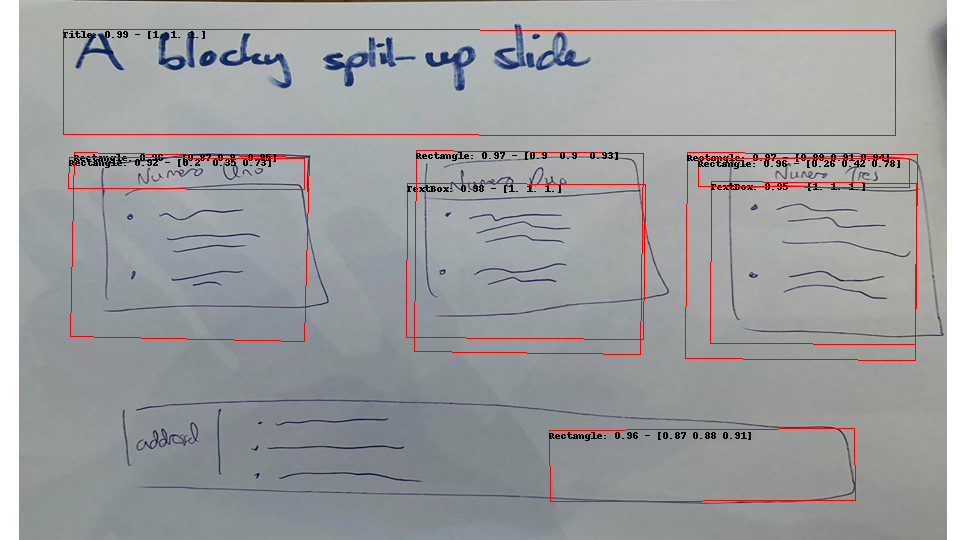

In [51]:

image, outputs = test(64, 0.9)
image

In [52]:
import win32com.client
from lib.ppt_interface import PPT_shapes
import random
Application = win32com.client.Dispatch('PowerPoint.Application')
shape_manager = PPT_shapes()
from lib.ppt_interface import write_slide
from lib.app_interface import get_readout




In [53]:
readout = get_readout(image, outputs, id2label, threshold=0.6)
write_slide(readout, Application.ActivePresentation, shape_manager, idx=Application.ActiveWindow.View.Slide.SlideIndex)

In [39]:
image = train_dataset.coco.loadImgs(0)[0]

image = Image.open(os.path.join(f'{DATA_BASE}/train', image['file_name']))
# Image is a PIl image



(1333, 750)

In [20]:
current_slide = Application.ActiveWindow.View.Slide
for shape in current_slide.shapes:
    print(shape.Name)
    try:
        if "@AG create" in shape.TextFrame.TextRange.Text:
            shape.Delete
            break
    except:
        pass



Rectangle 40
Title 1
Straight Connector 3
TextBox 6
TextBox 9
Straight Connector 10
Straight Connector 12
TextBox 14
Straight Connector 15
TextBox 16
TextBox 17
TextBox 18
TextBox 19
TextBox 20
TextBox 21
TextBox 22
TextBox 23
TextBox 24
TextBox 25
TextBox 26
TextBox 27
TextBox 28
TextBox 29
TextBox 30
TextBox 31
TextBox 32
TextBox 33
TextBox 34
Rectangle 35
Rectangle 36
Rectangle 37
Rectangle 38
TextBox 39
Folded Corner 2


In [22]:
shape.delete()
python Desktop/artificial_graphics/app.py


In [19]:
val_dataset.coco.imgToAnns[9]

[{'id': 74,
  'image_id': 9,
  'category_id': 0,
  'iscrowd': 0,
  'area': 86422.53158569336,
  'bbox': [66.0, 28.75, 828.0, 104.37503814697266],
  'segmentation': [],
  'angle': 0.0,
  'rotation': [1.0, 0.0],
  'fill': [1.0, 1.0, 1.0]},
 {'id': 75,
  'image_id': 9,
  'category_id': 1,
  'iscrowd': 0,
  'area': 18105.059098228812,
  'bbox': [520.9722290039062,
   287.4635314941406,
   29.29732322692871,
   617.9765625],
  'segmentation': [],
  'angle': 0.0,
  'rotation': [1.0, 0.0],
  'fill': [1.0, 1.0, 1.0]},
 {'id': 76,
  'image_id': 9,
  'category_id': 6,
  'iscrowd': 0,
  'area': 8457.770312875276,
  'bbox': [652.5560913085938,
   283.0004577636719,
   48.005985260009766,
   176.18157958984375],
  'segmentation': [],
  'angle': 0.0,
  'rotation': [1.0, 0.0],
  'fill': [0.0, 1.0, 0.0]},
 {'id': 77,
  'image_id': 9,
  'category_id': 7,
  'iscrowd': 0,
  'area': 12576.444551141001,
  'bbox': [343.7273864746094,
   241.77346801757812,
   66.83157348632812,
   188.18118286132812],
  'se

In [41]:
Presentation = Application.Presentations.Add()

In [ ]:
Presentation.close()